# Preparando ambiente

In [ ]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import fileinput
from sklearn import metrics


from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Carregando dados

#### Gerando mais cores

['apple', 'banana', 'orange'] 3

apple será a classe 0 no classificador
71 exemplos com as entradas: ['Red', 'Green', 'Blue']


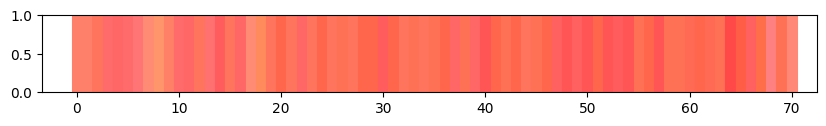


banana será a classe 1 no classificador
94 exemplos com as entradas: ['Red', 'Green', 'Blue']


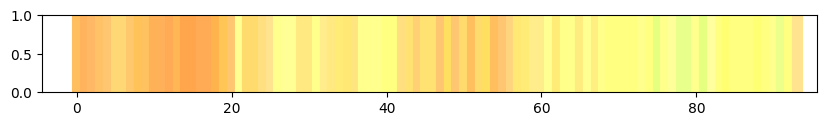


orange será a classe 2 no classificador
91 exemplos com as entradas: ['Red', 'Green', 'Blue']


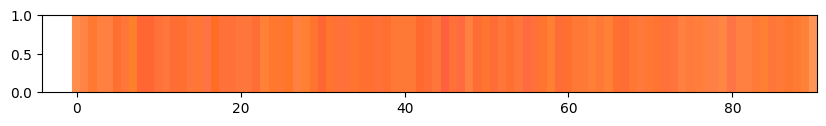

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASSES = []
PATH_DIR = '/content/drive/MyDrive/Projeto TinyML/Dados/'

for file in os.listdir(PATH_DIR):
  if file.endswith(".csv"):
    CLASSES.append(os.path.splitext(file)[0])

CLASSES.sort()
SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)
print(CLASSES, NUM_CLASSES)
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv(PATH_DIR + objectClass + ".csv")
  columns = list(df)
  df = df.reset_index(drop=True)

  num_recordings = int(df.shape[0] / SAMPLES_WINDOW_LEN)
  print(f"\n{objectClass} será a classe {class_index} no classificador")
  print(f"{num_recordings} exemplos com as entradas: {list(df)}")

  plt.rcParams["figure.figsize"] = (10,1)
  pixels = np.array([df['Red'],df['Green'],df['Blue']],float)
  pixels = np.transpose(pixels)
  for i in range(num_recordings):
    plt.axvline(x=i, linewidth=8, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
  plt.show()

  # Tensores
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

In [ ]:
min_variations = 100
PATH_DIR = '/content/drive/MyDrive/Projeto TinyML/Dados/'

original_data = pd.read_csv(PATH_DIR+'/apple.csv')

num_variations_needed = min_variations - len(original_data)
new_variations = []
for i in range(num_variations_needed):
  noise = np.random.normal(0, 0.1, size=(len(original_data), 3))
  noise[:, 0] += np.random.normal(0.15, 0.0, size=len(original_data))
  variation = original_data[['Red', 'Green', 'Blue']] + noise
  variation = np.clip(variation, 0, 255)

  new_variations.append(variation)


nova_maca = pd.concat([original_data] + new_variations, ignore_index=True)
nova_maca.to_csv(PATH_DIR+'/dados_aumentados/maca.csv', index=False)

print("Número total de variações após aumento de dados:", len(nova_maca))
num_recordings_maca = int(nova_maca.shape[0])

Número total de variações após aumento de dados: 2130


In [ ]:
min_variations = 120
original_data = pd.read_csv(PATH_DIR+'/banana.csv')

num_variations_needed = min_variations - len(original_data)
new_variations = []
for i in range(num_variations_needed):
    noise = np.random.normal(0, 0.1, size=(len(original_data), 3))
    noise[:, 0] += np.random.normal(0.15, 0.0, size=len(original_data))
    noise[:, 1] += np.random.normal(0.15, 0.0, size=len(original_data))
    variation = (original_data[['Red', 'Green', 'Blue']] + noise)
    variation = np.clip(variation, 0, 255)

    new_variations.append(variation)

banana_new_data = pd.concat([original_data] + new_variations, ignore_index=True)
banana_new_data.to_csv(PATH_DIR+'/dados_aumentados/banana.csv', index=False)

print("Número total de variações após aumento de dados:", len(banana_new_data))

num_recordings_banana = int(banana_new_data.shape[0])

Número total de variações após aumento de dados: 2538


In [ ]:
def change_to_green(r, g, b):
    r *= 0.3
    g *= 1.5
    return r, g, b

min_variations = 120
original_data = pd.read_csv(PATH_DIR+'orange.csv')

num_variations_needed = min_variations - len(original_data)
new_variations = []
for i in range(num_variations_needed):
    noise = np.random.normal(0, 0.1, size=(len(original_data), 3))
    variation = original_data[['Red', 'Green', 'Blue']] + noise
    variation['Red'], variation['Green'], variation['Blue'] = zip(*variation.apply(lambda row: change_to_green(row['Red'], row['Green'], row['Blue']), axis=1))
    variation = np.clip(variation, 0, 255)

    new_variations.append(variation)

limao_new = pd.concat(new_variations, ignore_index=True)
limao_new.to_csv(PATH_DIR+'/dados_aumentados/limao.csv', index=False)

print("Número total de variações após aumento de dados:", len(limao_new))

num_recordings_limao = int(limao_new.shape[0])

Número total de variações após aumento de dados: 2639


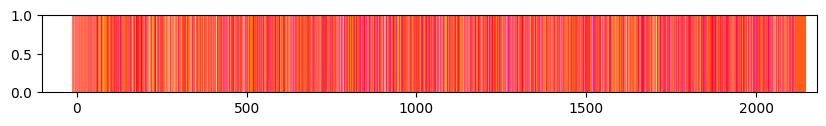

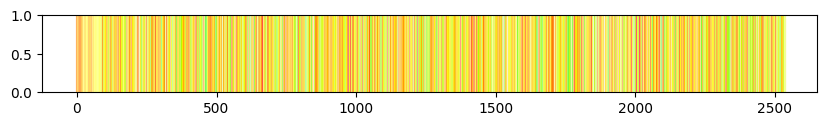

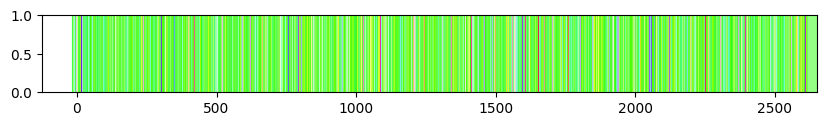

In [ ]:
plt.rcParams["figure.figsize"] = (10,1)
pixels = np.array([nova_maca['Red'],nova_maca['Green'],nova_maca['Blue']],float)
pixels = np.transpose(pixels)
for i in range(num_recordings_maca):
  plt.axvline(x=i, linewidth=8, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
plt.show()

plt.rcParams["figure.figsize"] = (10,1)
pixels = np.array([banana_new_data['Red'],banana_new_data['Green'],banana_new_data['Blue']],float)
pixels = np.transpose(pixels)
for i in range(num_recordings_banana):
  plt.axvline(x=i, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
plt.show()

plt.rcParams["figure.figsize"] = (10,1)
pixels = np.array([limao_new['Red'], limao_new['Green'], limao_new['Blue']], float)
pixels = np.transpose(pixels)
for i in range(num_recordings_limao):
    plt.axvline(x=i, linewidth=8, color=tuple(pixels[i] / np.max(pixels[i], axis=0)))
plt.show()

#### Carregando novas cores

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASSES = []
PATH_DIR = '/content/drive/MyDrive/Projeto TinyML/Dados/dados_aumentados/'

for file in os.listdir(PATH_DIR):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])

CLASSES.sort()
SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)
print(CLASSES, NUM_CLASSES)


['banana', 'limao', 'maca'] 3


In [ ]:
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []


banana será a classe 0 no classificador
2538 exemplos com as entradas: ['Red', 'Green', 'Blue']


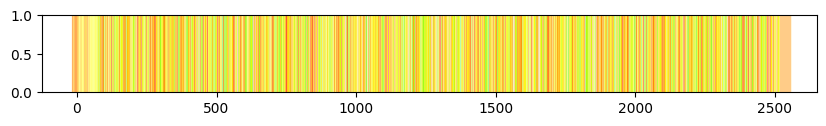


limao será a classe 1 no classificador
2639 exemplos com as entradas: ['Red', 'Green', 'Blue']


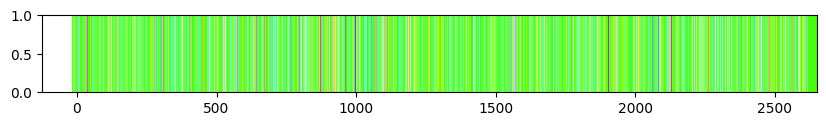


maca será a classe 2 no classificador
2130 exemplos com as entradas: ['Red', 'Green', 'Blue']


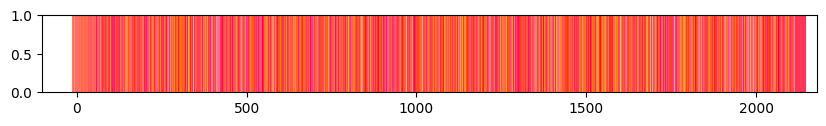

In [ ]:
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv(PATH_DIR + objectClass + ".csv")
  columns = list(df)
  df = df.reset_index(drop=True)

  num_recordings = int(df.shape[0] / SAMPLES_WINDOW_LEN)
  print(f"\n{objectClass} será a classe {class_index} no classificador")
  print(f"{num_recordings} exemplos com as entradas: {list(df)}")

  plt.rcParams["figure.figsize"] = (10,1)
  pixels = np.array([df['Red'],df['Green'],df['Blue']],float)
  pixels = np.transpose(pixels)
  for i in range(num_recordings):
    plt.axvline(x=i, linewidth=8, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
  plt.show()

  # Tensores
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

In [ ]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Misturar dados
inputs = inputs[randomize]
outputs = outputs[randomize]

TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

# Modelo

## Treino

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=4,
                   validation_data=(inputs_validate, outputs_validate))

In [ ]:
test_loss, test_accuracy = model.evaluate(inputs_test, outputs_test)
print(f"Acurácia no conjunto de teste: {test_accuracy}")

46/46 [==============================] - 0s 1ms/step - loss: 0.0909 - accuracy: 0.9644
Acurácia no conjunto de teste: 0.9644079208374023


## Teste

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

reais = []
preds = []

for i in range(predictions.shape[0]):
  item = predictions[i,:]
  pred = np.argmax(item)
  preds.append(pred)

  item2 = outputs_test[i,:]
  real = np.argmax(item2)
  reais.append(real)

46/46 [==============================] - 0s 1ms/step


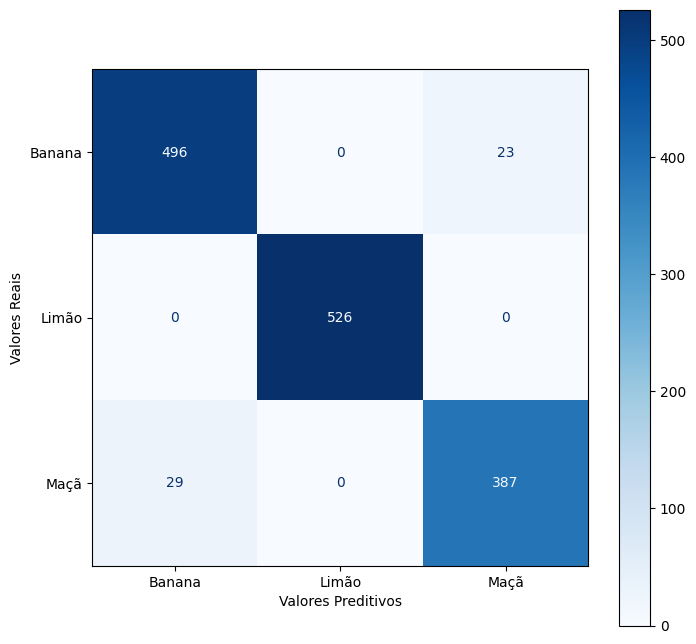

In [ ]:
confusion_matrix = metrics.confusion_matrix(reais, preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Banana", "Limão", "Maçã"])

fig, ax = plt.subplots(figsize=(8, 8))
cmap = plt.get_cmap('Blues')
cm_display.plot(ax=ax, cmap=cmap)

ax.set_xlabel('Valores Preditivos')
ax.set_ylabel('Valores Reais')

# plt.title("Matriz de confusão", fontsize=12)
plt.show()

# Converter para TensorflowLite

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
with open(PATH_DIR+"model.tflite", "wb") as f:
    f.write(tflite_model)

import os
basic_model_size = os.path.getsize(PATH_DIR+"model.tflite")
print("Model is %d bytes" % basic_model_size)


Model is 3084 bytes


In [ ]:
!echo "const unsigned char model[] = {" >
  '/content/drive/MyDrive/Projeto TinyML/Dados/dados_aumentados/model.h'

!cat '/content/drive/MyDrive/Projeto TinyML/Dados/dados_aumentados/model.tflite' | xxd -i >>
  '/content/drive/MyDrive/Projeto TinyML/Dados/dados_aumentados/model.h'

!echo "};"                              >>
  '/content/drive/MyDrive/Projeto TinyML/Dados/dados_aumentados/model.h'

print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 19,052 bytes.


# Testar valores dos sensores

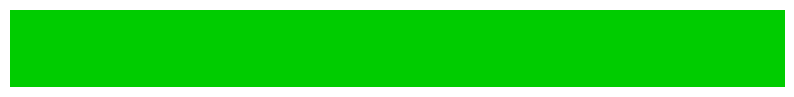

1/1 [==============================] - 0s 47ms/step
Classe prevista: limao


In [ ]:
import matplotlib.pyplot as plt
color = [0,0.8,0]
def plot_color(color):
  plt.figure()
  plt.imshow([[color]], aspect='auto')
  plt.axis('off')
  plt.show()


plot_color(color)

# Fazendo previsões com o modelo
predictions_real = model.predict([color])

# Determinando a classe prevista
class_index = np.argmax(predictions_real[0, :])
predicted_class = CLASSES[class_index]

print("Classe prevista:", predicted_class)